In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import pickle
import re


In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Update NCBITaxa database

In [3]:
updata_database = False

from ete3 import NCBITaxa
ncbi = NCBITaxa()
if updata_database:
    ncbi.update_taxonomy_database()

/work/PCDC/s198665/conda_envs/envir_MB-SupCon/lib/python3.8/site-packages/ete3-3.1.2-py3.7.egg/ete3/evol/parser/codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?
/work/PCDC/s198665/conda_envs/envir_MB-SupCon/lib/python3.8/site-packages/ete3-3.1.2-py3.7.egg/ete3/evol/parser/codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?


# Enrichment analysis

In [4]:
def marker_taxa_name_to_NCBIid(taxa_name):
    genus_name = []
    for tn in taxa_name:
        import re
        if re.search(r'\|g__', tn):
            gn = re.split(r'\|', re.split('\|g__', tn)[1])[0]
            genus_name.append(re.split(r'[\_\-\.]', gn)[0])

    genus_name = list(set(genus_name))
    name2taxid = ncbi.get_name_translator(genus_name)
    taxid = [name2taxid[_][0] for _ in name2taxid]
    ranks_dict = ncbi.get_rank(taxid)
    taxid = [_ for _ in taxid if ranks_dict[_] == 'genus']
    
    return taxid

In [5]:
def all_taxa_name_to_NCBIid(taxa_name):
    genus_name = []
    for i in range(len(taxa_name)):
        tn=taxa_name[i]
        import re
        if re.search(r'; g__', tn):
            gn = re.split(r'; ', re.split('; g__', taxa_name[i])[1])[0]
            genus_name.append(re.split(r'[\_\-\.]', gn)[0])

    genus_name = list(set(genus_name))
    name2taxid = ncbi.get_name_translator(genus_name)
    taxid = [name2taxid[_][0] for _ in name2taxid]
    ranks_dict = ncbi.get_rank(taxid)
    taxid = [_ for _ in taxid if ranks_dict[_] == 'genus']
    
    return taxid

In [6]:
def enrichment_analysis(influence_by_microbe_all_df, lrp_result_dict, genus_included_NCBIid, marker_taxa_NCBIid):
    
    '''
    genus_included_NCBIid: list/array of NCBI ID's of all genus included in validation cohort;
    marker_taxa_NCBIid: list/array of NCBI ID's of marker genus in validation cohort.
    '''
    
    taxa_name = list(influence_by_microbe_all_df.columns)
    genus_name = [tn.split('__')[-1] for tn in taxa_name]
    genus_name = [gn.replace('.', ' ') for gn in genus_name]
    ### in particular: use "Liberibacter" to replace "Candidatus Liberibacter"
    genus_name = [gn.replace('Candidatus Liberibacter', 'Liberibacter') for gn in genus_name]
    genus_name_nona = [gn for gn in genus_name if gn != '']

    name2taxid = ncbi.get_name_translator(genus_name_nona)
    taxid = [name2taxid[_][0] for _ in name2taxid]
    ranks_dict = ncbi.get_rank(taxid)
    taxid = [_ for _ in taxid if ranks_dict[_] == 'genus']

    # Drop duplicate NCBI ids
    genus_included_taxid = list(set(genus_included_NCBIid))
    marker_genus_taxid = list(set(marker_taxa_NCBIid))
    
    common_taxid = list(set(taxid) & set(genus_included_taxid)) # S
    
    tables, odds_ratios, pvalues = [], [], []
    overlapped_taxa_dict = {}
    
    for cov in lrp_result_dict['y_col_names']:
        influential_taxa = lrp_result_dict['marker_genera_dict'][cov]
        
        influential_name2taxid = ncbi.get_name_translator(influential_taxa)
        influential_taxid = [influential_name2taxid[_][0] for _ in influential_name2taxid]
        influential_taxid = list(set(influential_taxid))
        
        n_marker_and_lrp_influential = len(list(set(influential_taxid) & set(marker_genus_taxid))) # #{L \cap R}
        n_lrp_influential = sum(np.isin(influential_taxid, common_taxid)) # #{L \cap S} row 1 sum
        n_val_marker = sum(np.isin(marker_genus_taxid, common_taxid)) # #{R \cap S} col 1 sum

        table_11 = n_marker_and_lrp_influential # a
        table_12 = n_lrp_influential - n_marker_and_lrp_influential # b
        table_21 = n_val_marker - n_marker_and_lrp_influential # c
        table_22 = len(common_taxid) - table_11 - table_12 - table_21 # d
        
        overlapped_taxid = list(set(influential_taxid) & set(marker_genus_taxid))  
        overlapped_taxa_dict[cov] = list(ncbi.get_taxid_translator(overlapped_taxid).values())
        
        from scipy.stats import fisher_exact
        table = np.array([[table_11, table_12], 
                          [table_21, table_22]])
        odds_ratio, pvalue = fisher_exact(table, alternative='greater')
        
        tables.append(table)
        odds_ratios.append(odds_ratio)
        pvalues.append(pvalue)
        
    return tables, odds_ratios, pvalues, overlapped_taxa_dict

In [7]:
def post_analysis(disease, genus_included_NCBIid, marker_taxa_NCBIid):
    import numpy as np
    X_microbiome = pd.read_pickle('./data/processed data/{}_microbiome_clean.pkl'.format(disease))
    with open(os.path.join('./results/LRP/{}/lrp_result_dict.pkl'.format(disease)), "rb") as f:
        lrp_result_dict = pickle.load(f)
        
    pred_result_save_folder = './results/%s' % disease
    with open(os.path.join(pred_result_save_folder, '{}_prediction_result_dict.pkl'.format(disease)), 'rb') as f:
        prediction_result_dict = pickle.load(f)

    influence_by_microbe_all_df = pd.DataFrame(lrp_result_dict['influence_by_microbe_all'],
                                              index=lrp_result_dict['y_col_names'], columns=X_microbiome.columns)
    
    tables, odds_ratios, pvalues, overlapped_taxa_dict = enrichment_analysis(influence_by_microbe_all_df, lrp_result_dict,
                                                                             genus_included_NCBIid, marker_taxa_NCBIid)

    from statsmodels.stats.multitest import multipletests
    rejects, pvalues_corrected, _, _ = multipletests(pvals=pvalues, alpha=0.05, method='fdr_bh', is_sorted=False)

    sig_contingency_name = influence_by_microbe_all_df.index[rejects]
    
    # Order the significant covariate names by an ascending order of micro average AUC scores
    if type(list(prediction_result_dict['auc'].values())[0]) == tuple:
        auc_socre = [prediction_result_dict['auc'][cov][0] for cov in sig_contingency_name]
    else:
        auc_socre = [prediction_result_dict['auc'][cov] for cov in sig_contingency_name]
    order_idx = sorted(range(len(auc_socre)), key=lambda k: auc_socre[k], reverse=True)
    sig_contingency_name = np.array(sig_contingency_name)[order_idx]
    
    ind = [list(influence_by_microbe_all_df.index).index(cov) for cov in sig_contingency_name]
    
    sig_tables_dict = dict(zip(sig_contingency_name, np.array(tables)[ind]))
    sig_c_pvalues_dict = dict(zip(sig_contingency_name, np.array(pvalues_corrected)[ind]))

    sorted_sig_c_pvalues_dict = dict(sorted(sig_c_pvalues_dict.items(), key = lambda kv: kv[1]))
    sorted_sig_tables_dict = dict(zip(sorted_sig_c_pvalues_dict.keys(), [sig_tables_dict[key] for key in sorted_sig_c_pvalues_dict.keys()]))

    all_tables_dict = dict(zip(influence_by_microbe_all_df.index, tables))
    all_c_pvalues_dict = dict(zip(influence_by_microbe_all_df.index, pvalues_corrected))

    result_save_folder = os.path.join('./', 'results/ORA/{}'.format(disease))
    with open(os.path.join(result_save_folder, '{}_overlapped_taxa_dict.pkl'.format(disease)), 'wb') as f:
        pickle.dump(overlapped_taxa_dict, f)
    with open(os.path.join(result_save_folder, '{}_sig_tables_dict.pkl'.format(disease)), 'wb') as f:
        pickle.dump(sorted_sig_tables_dict, f)
    with open(os.path.join(result_save_folder, '{}_sig_c_pvalues_dict.pkl'.format(disease)), 'wb') as f:
        pickle.dump(sorted_sig_c_pvalues_dict, f)
    with open(os.path.join(result_save_folder, '{}_all_tables_dict.pkl'.format(disease)), 'wb') as f:
        pickle.dump(all_tables_dict, f)
    with open(os.path.join(result_save_folder, '{}_all_c_pvalues_dict.pkl'.format(disease)), 'wb') as f:
        pickle.dump(all_c_pvalues_dict, f)
    
    return sorted_sig_tables_dict, sorted_sig_c_pvalues_dict

In [8]:
def proportion_barchart(disease, sig_tables_dict, sig_c_pvalues_dict, xlab, cols_palette= "Set1",
                        star_y=0.45, figsize=(14,6), fontsize=30, prop_size=20, legend_size=20, rotation=340):
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns

    sig_contingency_name = list(sig_tables_dict.keys())
    proportion_lrp = np.array(list(map(lambda x: x[0,0]/(x[0,0]+x[0,1]), sig_tables_dict.values()))) # a/(a+b)
    proportion_background = np.array(list(map(lambda x: (x[0,0]+x[1,0])/np.sum(x), sig_tables_dict.values()))) # (a+c)/(a+b+c+d)
    proportion_df = pd.DataFrame({'Proportion': np.concatenate((proportion_lrp, proportion_background)),
                                 'Covariate': np.tile(sig_contingency_name, 2),
                                 'Value': np.repeat(['% in MB-LRP biomarker set', '% in background'], 
                                                    len(sig_contingency_name))})
    selected_pvalues = np.array(list(sig_c_pvalues_dict.values()))
    star_sign = np.select([selected_pvalues < 0.001, (selected_pvalues >= 0.001)&(selected_pvalues<0.01), 
                           selected_pvalues>=0.01], ['***','**','*'])
    if type(cols_palette) == str:
        palette = cols_palette
    else: palette = {'% in MB-LRP biomarker set':cols_palette[0], '% in background':cols_palette[1]}

    import seaborn as sns
    import matplotlib.pyplot as plt 

    fig, ax = plt.subplots(figsize=figsize)
    plt.tight_layout()
    ax = sns.barplot(x='Covariate', y='Proportion', data=proportion_df, hue='Value', 
                     palette=palette)
    ax.set_title('', fontsize=30)
    ax.tick_params(axis='both', labelsize=fontsize)
    ax.set_xlabel(xlab, fontsize=fontsize)
    xtick = ax.get_xticks()
    ax.set_xticks(xtick - .2)
    ax.xaxis.set_tick_params(length=0, width=0, which='major')
    ax.set_xticklabels(sig_contingency_name, rotation=rotation, fontsize=fontsize, ha='left')
    ax.set_ylim((0,1))
    ax.xaxis.get_label().set_fontsize(fontsize)
    ax.yaxis.get_label().set_fontsize(fontsize)
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=legend_size)
    for i in range(len(sig_contingency_name)): 
        ax.text(i-0.1, proportion_lrp[i]+0.004, '{:.2%}'.format(proportion_lrp[i]), size=prop_size,
               rotation=45, horizontalalignment='center', verticalalignment='bottom')
        ax.text(i+0.3, proportion_background[i]+0.004, '{:.2%}'.format(proportion_background[i]), size=prop_size,
               rotation=45, horizontalalignment='center', verticalalignment='bottom')
        #ax.text(i, proportion_lrp[i]+0.1, star_sign[i], fontsize=15, ha='center')
        ax.text(i, star_y, star_sign[i], fontsize=20, ha='center')
    plt.show()
    
    os.makedirs(f"./figures/barplot/", exist_ok=True)
    fig.savefig(f"./figures/barplot/{disease}.pdf", bbox_inches='tight')
    fig.savefig(f"./figures/barplot/{disease}.png", bbox_inches='tight')

### 1) COAD

In [9]:
genus_included = pd.read_csv("../data/GMrepoV2/genus_associated_with_D015179.tsv", sep='\t', 
                               index_col=False, header=3)
marker_taxa = pd.read_csv("../data/GMrepoV2/marker_taxa_in_phenotype_comparison_between_D006262_D015179.txt", sep='\t', 
                               index_col=False, header=1)
genus_included_NCBIid = genus_included['NCBI taxon id'].values
marker_taxa_NCBIid = marker_taxa.loc[marker_taxa['taxonomic rank'] == 'genus', 'ncbi taxon id']

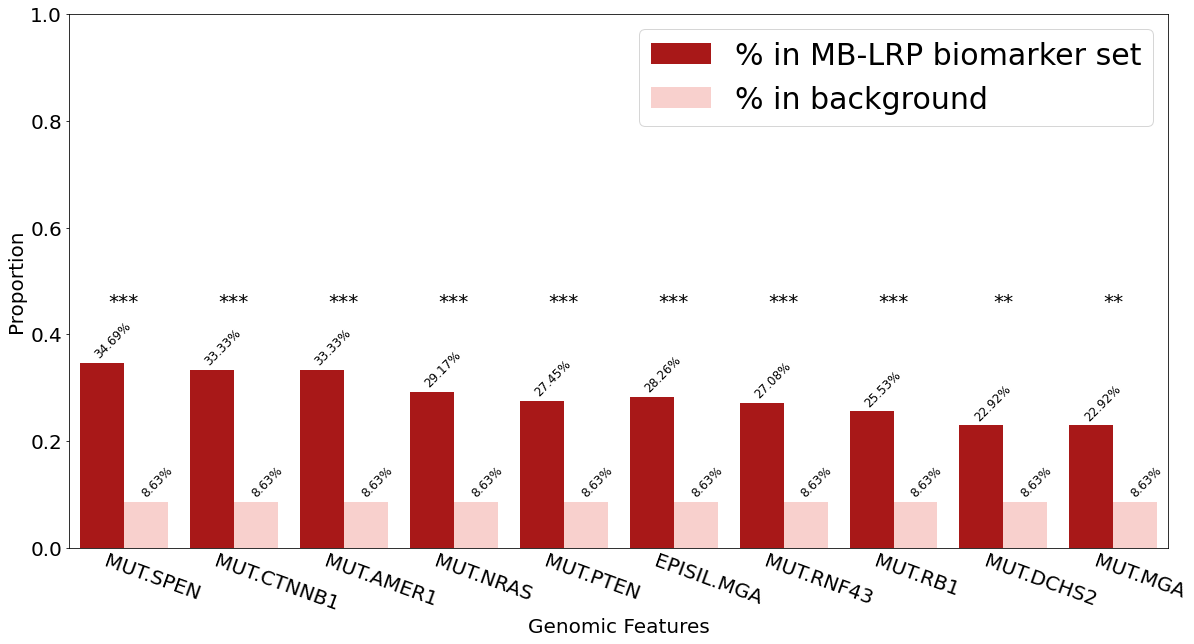

In [10]:
COAD_sig_tables_dict, COAD_sig_c_pvalues_dict = post_analysis('COAD', genus_included_NCBIid, marker_taxa_NCBIid)
proportion_barchart('COAD', COAD_sig_tables_dict, COAD_sig_c_pvalues_dict, 'Genomic Features', cols_palette=['#C00000', '#FFCAC6'],
                    figsize=(16,8), fontsize=20, prop_size=12, legend_size=30)

In [11]:
COAD_sig_tables_dict

{'MUT.SPEN': array([[ 17,  32],
        [ 53, 709]]),
 'MUT.CTNNB1': array([[ 16,  32],
        [ 54, 709]]),
 'MUT.AMER1': array([[ 16,  32],
        [ 54, 709]]),
 'MUT.NRAS': array([[ 14,  34],
        [ 56, 707]]),
 'MUT.PTEN': array([[ 14,  37],
        [ 56, 704]]),
 'EPISIL.MGA': array([[ 13,  33],
        [ 57, 708]]),
 'MUT.RNF43': array([[ 13,  35],
        [ 57, 706]]),
 'MUT.RB1': array([[ 12,  35],
        [ 58, 706]]),
 'MUT.DCHS2': array([[ 11,  37],
        [ 59, 704]]),
 'MUT.MGA': array([[ 11,  37],
        [ 59, 704]])}

In [12]:
COAD_sig_c_pvalues_dict

{'MUT.SPEN': 9.144296649487299e-07,
 'MUT.CTNNB1': 1.5117232843093627e-06,
 'MUT.AMER1': 1.5117232843093627e-06,
 'MUT.NRAS': 4.1181842718100303e-05,
 'MUT.PTEN': 7.161074097024229e-05,
 'EPISIL.MGA': 8.487753303888813e-05,
 'MUT.RNF43': 0.00011981098607089355,
 'MUT.RB1': 0.00038256040309771254,
 'MUT.DCHS2': 0.0015281605403386256,
 'MUT.MGA': 0.0015281605403386256}

### 2) STAD

In [13]:
all_taxa_name_df = pd.read_csv("../data/lefse_data_2/kw0.5_lda0.1/lefse.gc.gastric.cancer.lyu.2021.taxa.name.csv",
                               header=0, index_col=0)
all_taxa_name = all_taxa_name_df['marker'].values
genus_included_NCBIid = all_taxa_name_to_NCBIid(all_taxa_name)

In [14]:
marker_taxa_name_df = pd.read_csv("../data/lefse_data_2/kw0.5_lda0.1/lefse.gc.gastric.cancer.lyu.2021.csv",
                               header=0, index_col=0)
idx = [(marker_taxa_name_df['pvalue']<=0.05).values[i] and (marker_taxa_name_df['ef_lda']>=2).values[i] \
       for i in range(marker_taxa_name_df.shape[0])]
marker_taxa_name_df = marker_taxa_name_df.loc[idx,:]
marker_taxa_name = marker_taxa_name_df['feature'].values
marker_taxa_NCBIid = marker_taxa_name_to_NCBIid(marker_taxa_name)
len(marker_taxa_NCBIid)

43

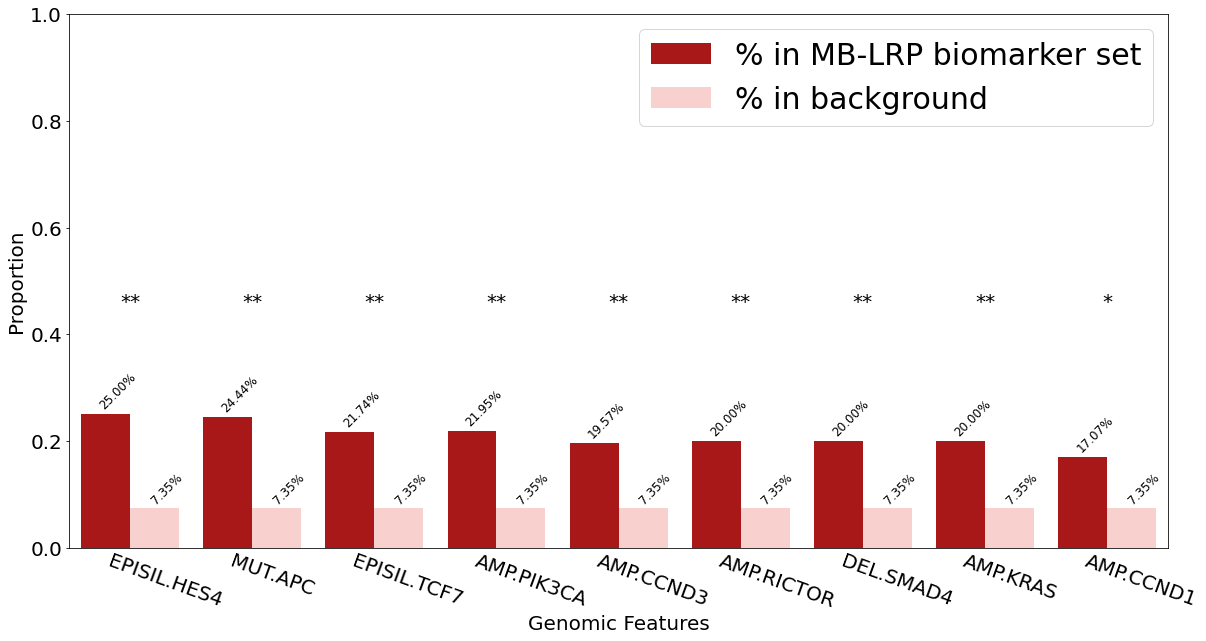

In [15]:
STAD_sig_tables_dict, STAD_sig_c_pvalues_dict = post_analysis('STAD', genus_included_NCBIid, marker_taxa_NCBIid)
proportion_barchart('STAD', STAD_sig_tables_dict, STAD_sig_c_pvalues_dict, 'Genomic Features', cols_palette=['#C00000', '#FFCAC6'],
                    figsize=(16,8), fontsize=20, prop_size=12, legend_size=30)

In [16]:
STAD_sig_tables_dict

{'EPISIL.HES4': array([[ 10,  30],
        [ 25, 411]]),
 'MUT.APC': array([[ 11,  34],
        [ 24, 407]]),
 'EPISIL.TCF7': array([[ 10,  36],
        [ 25, 405]]),
 'AMP.PIK3CA': array([[  9,  32],
        [ 26, 409]]),
 'AMP.CCND3': array([[  9,  37],
        [ 26, 404]]),
 'AMP.RICTOR': array([[  9,  36],
        [ 26, 405]]),
 'DEL.SMAD4': array([[  8,  32],
        [ 27, 409]]),
 'AMP.KRAS': array([[  8,  32],
        [ 27, 409]]),
 'AMP.CCND1': array([[  7,  34],
        [ 28, 407]])}

In [17]:
STAD_sig_c_pvalues_dict

{'EPISIL.HES4': 0.0011215109707313148,
 'MUT.APC': 0.0011215109707313148,
 'EPISIL.TCF7': 0.002623574961924499,
 'AMP.PIK3CA': 0.003594507064785135,
 'AMP.CCND3': 0.0057582571196245986,
 'AMP.RICTOR': 0.0057582571196245986,
 'DEL.SMAD4': 0.006603301621734259,
 'AMP.KRAS': 0.006603301621734259,
 'AMP.CCND1': 0.02510304064466844}